<a href="https://colab.research.google.com/github/siddhish2006/aimlassignmentsiddhish/blob/main/aimlsiddhish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans


In [ ]:
df = pd.read_csv("snu_data.csv")
display(df.head())

,Timestamp,Age,"Height\nRange should be between 120 cm - 220 cm\nNote(Provide the height in integer for eg-124cm ,\n don't provide like 120.64)",Weight\nRange should be between 30 - 150 kg,Cuisine_top1,Cuisine_top2,Cuisine_top3,Spice Tolerance,Dietary Preference,Eating Out Per week,...,Hobby_top1,Hobby top2,Club top1,Club top 2,Weekly_hobby_hours \nprovide values integer between between 0-40,Introversion extraversion,Risk taking,Conscientiousness,Open to new experiences,"Teamwork preference \n Like: ( 1=Prefer Solo, 5=Prefer Teams)"
0,8/27/2025 11:13:12,Age-21,120,30,Mughlai,Bengali,Japanese,2,Jain,7,...,Cricket,Writing,Robotics Club,Music Club,0,2,2,2,2,3
1,8/27/2025 13:19:21,Age-19,167,50,Indian,Mexican,Street Food,5,Non-Veg,7,...,Coding,Cricket,Coding Club,Sports Club,40,3,2,3,5,3
2,8/27/2025 13:20:10,Age-20,167,60,Bengali,Mughlai,Italian,5,Non-Veg,3,...,Cricket,Coding,Coding Club,Sports Club,5,3,4,3,4,3
3,8/27/2025 13:21:56,Age-22,170,53,Indian,Chinese,Street Food,4,Non-Veg,7,...,Cricket,Music,Entrepreneurship Cell,Sports Club,10,5,5,5,5,5
4,8/27/2025 13:23:18,Age-21,167 cm,80 kg,Indian,Mughlai,Chinese,3,Non-Veg,4,...,Badminton,Debate,Literary Club,Entrepreneurship Cell,5,3,5,4,4,1


In [ ]:
cat_cols = ["gaming_platform_top1", "social_platform_top1", "ott_top1", "content_creation_freq"]
encoders = {col: LabelEncoder().fit(df[col]) for col in cat_cols}

for col in cat_cols:
    df[col] = encoders[col].transform(df[col])



In [ ]:
scaler = StandardScaler()
X = df[cat_cols + ["daily_social_media_minutes"]].copy()
X["daily_social_media_minutes"] = scaler.fit_transform(
    X[["daily_social_media_minutes"]]
)

X = X.to_numpy()


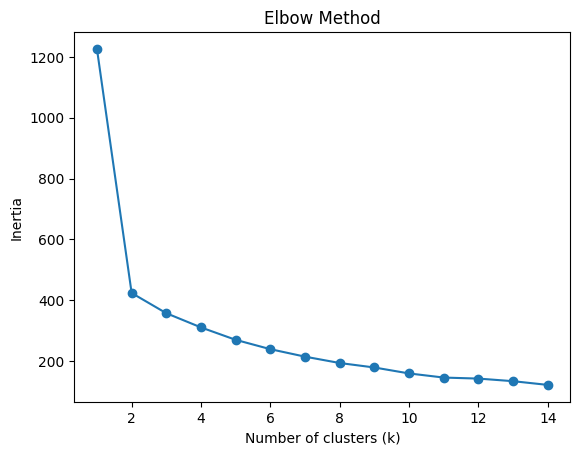

In [ ]:
ks = []
inertias = []

for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    ks.append(k)
    inertias.append(kmeans.inertia_)

plt.plot(ks, inertias, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

In [ ]:
k_opt = 2
kmeans_model = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
kmeans_model.fit(X)

df["Cluster"] = kmeans_model.labels_


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray() if hasattr(X, "toarray") else X)

labels = kmeans_model.labels_
uniq = np.unique(labels)
K = len(uniq)

/tmp/ipython-input-3022673907.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", K)


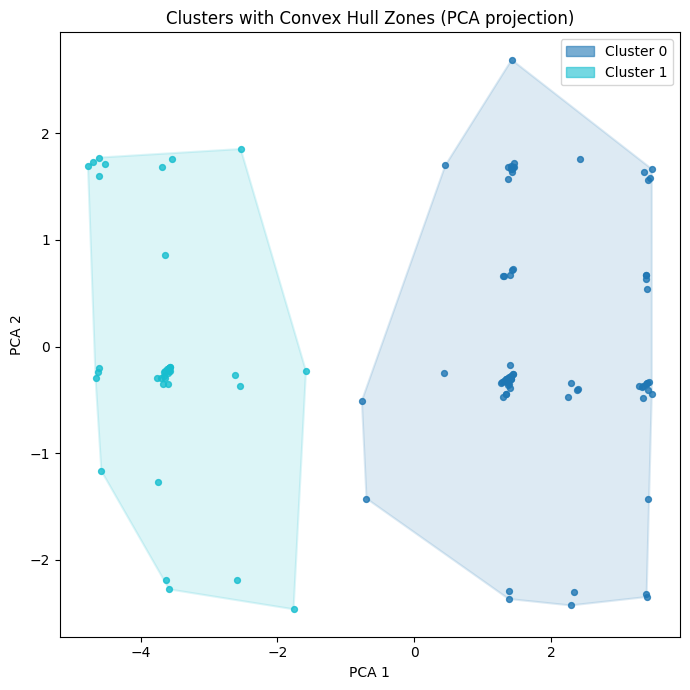

In [ ]:
from scipy.spatial import ConvexHull
from matplotlib.patches import Patch
cmap = plt.cm.get_cmap("tab10", K)
lab2idx = {lab: i for i, lab in enumerate(uniq)}

plt.figure(figsize=(7, 7))
legend_handles = []

for lab in uniq:
    idx = (df["Cluster"] == lab)
    pts = X_pca[idx]

    # Cluster color
    c = cmap(lab2idx[lab])

    # Scatter points
    plt.scatter(pts[:, 0], pts[:, 1], s=18, color=c, alpha=0.8, label=f"Cluster {lab}")

    # Convex hull if enough points
    if pts.shape[0] >= 3:
        hull = ConvexHull(pts)
        poly = pts[hull.vertices]
        poly = np.vstack([poly, poly[0]])
        plt.fill(poly[:, 0], poly[:, 1], facecolor=c, alpha=0.15,
                 edgecolor=c, linewidth=1.5)

    legend_handles.append(Patch(facecolor=c, edgecolor=c, alpha=0.6, label=f"Cluster {lab}"))

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Clusters with Convex Hull Zones (PCA projection)")
plt.legend(handles=legend_handles, loc="best")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Evaluate clustering quality safely
if hasattr(kmeans_model, "labels_"):
    sil_score = silhouette_score(X, kmeans_model.labels_)
    db_index = davies_bouldin_score(X, kmeans_model.labels_)

    print(f"Silhouette Score: {sil_score:.3f}")
    print(f"Davies–Bouldin Index: {db_index:.3f}")
else:
    print("Error: kmeans_model does not have labels_. Did you fit the model?")


Silhouette Score: 0.572
Davies–Bouldin Index: 0.640
